In [1]:
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, preprocessing
from tensorflow.keras.applications import MobileNetV2

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2025-07-23 18:11:40.249927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753294300.467636      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753294300.525882      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data preparation

In [2]:
shutil.copytree("/kaggle/input/gender-recognizer/dataset", "/kaggle/working/dataset")

#there is men folder in woman we dont need
shutil.rmtree('/kaggle/working/dataset/WOMAN/MEN', ignore_errors=True)

Splitting the data into train and validation subsets

In [3]:
original_dir = "/kaggle/working/dataset"


train_dir = "/kaggle/working/train"
val_dir = "/kaggle/working/val"


val_ratio = 0.2


def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


for base_dir in [train_dir, val_dir]:
    for class_name in ["MEN", "WOMAN"]:
        ensure_dir(os.path.join(base_dir, class_name))


for class_name in ["MEN", "WOMAN"]:
    class_dir = os.path.join(original_dir, class_name)
    images = os.listdir(class_dir)
    images = [img for img in images if img.lower().endswith((".jpg", ".jpeg", ".png"))]

    random.shuffle(images)

    val_count = int(len(images) * val_ratio)
    val_images = images[:val_count]
    train_images = images[val_count:]

    for img_name in val_images:
        src = os.path.join(class_dir, img_name)
        dst = os.path.join(val_dir, class_name, img_name)
        shutil.copyfile(src, dst)

    for img_name in train_images:
        src = os.path.join(class_dir, img_name)
        dst = os.path.join(train_dir, class_name, img_name)
        shutil.copyfile(src, dst)

In [4]:
train_data = preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
)

val_data = preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=123,
)

Found 1033 files belonging to 2 classes.


I0000 00:00:1753294338.424139      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 258 files belonging to 2 classes.


In [5]:
def count_labels(dataset):
    counts = {0:0, 1:0}
    for images, labels in dataset:
        labels_np = labels.numpy()
        for l in labels_np:
            counts[int(l)] += 1
    return counts

print("Train class counts:", count_labels(train_data))
print("Val class counts:", count_labels(val_data))

Invalid SOS parameters for sequential JPEG


Train class counts: {0: 517, 1: 516}
Val class counts: {0: 129, 1: 129}


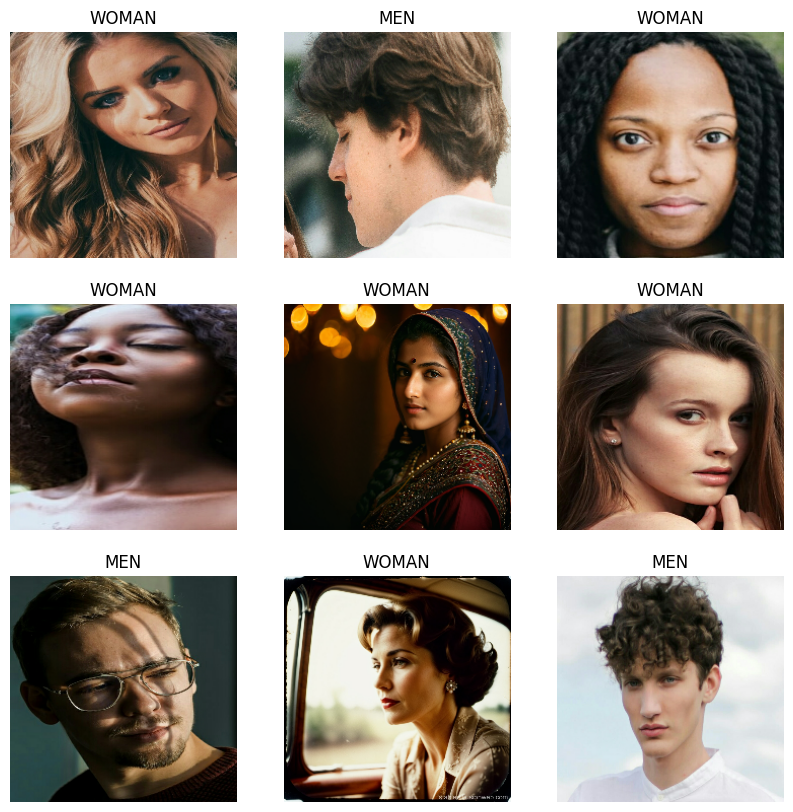

In [6]:
for images, labels in train_data.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        if img.shape[-1] == 1:
            img = img.squeeze(axis=-1)
        plt.imshow(img)
        plt.title(train_data.class_names[labels[i].numpy()].upper())
        plt.axis("off")
    plt.show()

In [7]:
def prediction_and_visualize(model,data):
    """
    This method take model returning raw predictions
    and 25 images with prediction label on top, and actual label on bottom
    For ease of visualization - frame it with color
    (green for correct, yellow for unshure, red for false)
    """
    pred = model.predict(data)
    def map_pred_to_label(prob):
      if prob > 0.7:
          return "WOMAN"
      elif prob < 0.3:
          return "MEN"
      else:
          return "UNSURE"

    pred_class_names = [map_pred_to_label(p[0]) for p in pred]
    val_loss, val_acc = model.evaluate(data, verbose=0)

    all_images = []
    all_labels = []

    for images, labels in data.map(lambda x, y: (x / 255.0, y)):
        all_images.append(images.numpy())
        all_labels.append(labels.numpy())


    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)


    num_samples = min(25, len(all_images))
    random_indices = np.random.choice(len(all_images), size=num_samples, replace=False)

    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(random_indices):
        ax = plt.subplot(5, 5, i + 1)
        img = all_images[idx]
        plt.imshow(img)

        true_label = data.class_names[all_labels[idx]].upper()
        pred_label = pred_class_names[idx]

        if pred_label == true_label:
            edge_color = 'lime'
        elif pred_label == "UNSURE":
            edge_color = 'yellow'
        else:
            edge_color = 'red'

        rect = patches.Rectangle(
            (0, 0), img.shape[1], img.shape[0],
            linewidth=5, edgecolor=edge_color, facecolor='none'
        )
        ax.add_patch(rect)

        plt.title(pred_label)
        ax.set_xlabel(true_label)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.suptitle(f'Accuracy on validation data {val_acc*100:.2f}%', color="red")
    plt.tight_layout()
    plt.show()
    return pred

# First model

In [8]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=9, restore_best_weights=True)

model_v1_raw = keras.Sequential([
    layers.Rescaling(1./255), #normalization
    layers.Conv2D(64, 2, activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, 2, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, 2, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(128, 2, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model_v1_raw.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
history = model_v1_raw.fit(
    train_data,
    batch_size=50,
    epochs=50,
    validation_data=val_data,
    callbacks=[early_stopping_callback]
)

Epoch 1/50


I0000 00:00:1753294355.705560      66 service.cc:148] XLA service 0x7fe670406ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753294355.706296      66 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
Invalid SOS parameters for sequential JPEG
I0000 00:00:1753294356.608790      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/33 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.5547 - loss: 1.5728

I0000 00:00:1753294363.872828      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 375ms/step - accuracy: 0.6221 - loss: 2.5865 - val_accuracy: 0.5620 - val_loss: 0.7333
Epoch 2/50
 2/33 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.8203 - loss: 0.8313

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.7457 - loss: 1.1636 - val_accuracy: 0.5155 - val_loss: 1.8688
Epoch 3/50
 2/33 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.7031 - loss: 0.9129

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.7921 - loss: 0.6487 - val_accuracy: 0.5620 - val_loss: 1.4301
Epoch 4/50
 1/33 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.7812 - loss: 0.9483

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.8551 - loss: 0.4458 - val_accuracy: 0.5078 - val_loss: 3.6916
Epoch 5/50
15/33 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.8981 - loss: 0.2625

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.8957 - loss: 0.2858 - val_accuracy: 0.5349 - val_loss: 5.0345
Epoch 6/50
 6/33 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9033 - loss: 0.1937

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9237 - loss: 0.2022 - val_accuracy: 0.5388 - val_loss: 5.3959
Epoch 7/50
 1/33 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.9688 - loss: 0.0753

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9689 - loss: 0.1042 - val_accuracy: 0.4884 - val_loss: 13.5734
Epoch 8/50
 4/33 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9818 - loss: 0.0463

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9723 - loss: 0.0754 - val_accuracy: 0.5000 - val_loss: 7.6585
Epoch 9/50
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9774 - loss: 0.0516

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9774 - loss: 0.0517 - val_accuracy: 0.4961 - val_loss: 10.7957
Epoch 10/50
22/33 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9802 - loss: 0.0537

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9823 - loss: 0.0493 - val_accuracy: 0.5620 - val_loss: 6.9244


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step


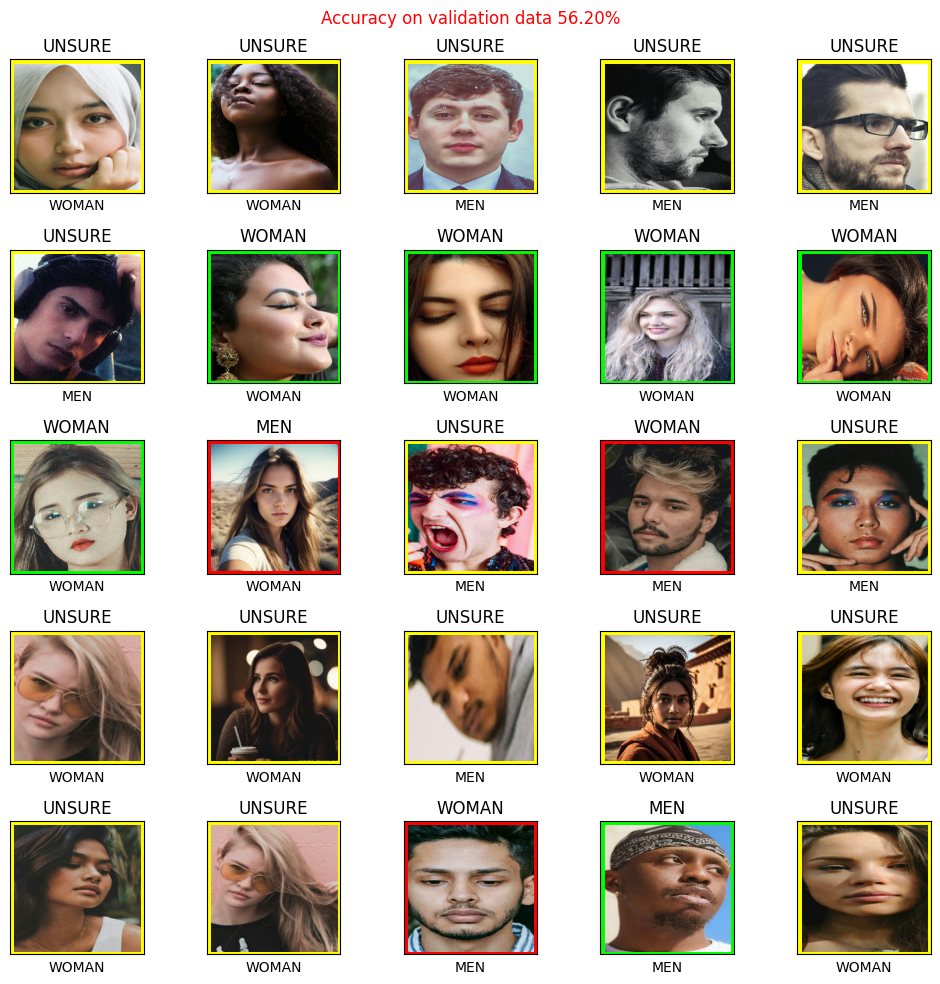

In [10]:
predictions_v1_raw = prediction_and_visualize(model_v1_raw, val_data)

#Augmentation

In [11]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])


model_V2_augm = keras.Sequential([
    layers.Rescaling(1./255),   #normalization
    data_augmentation,    #augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_V2_augm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [12]:
model_V2_augm.fit(train_data,
             validation_data=val_data,
             batch_size=50,
             epochs=50,
             callbacks=[early_stopping_callback]
             )

Epoch 1/50
14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.4855 - loss: 0.8627

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.5110 - loss: 0.7904 - val_accuracy: 0.6550 - val_loss: 0.6655
Epoch 2/50
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.5938 - loss: 0.6775

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.5981 - loss: 0.6650 - val_accuracy: 0.6318 - val_loss: 0.6236
Epoch 3/50
 6/33 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.6786 - loss: 0.6026

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.6418 - loss: 0.6320 - val_accuracy: 0.7132 - val_loss: 0.6030
Epoch 4/50
11/33 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.6951 - loss: 0.6082

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.6619 - loss: 0.6297 - val_accuracy: 0.7171 - val_loss: 0.5791
Epoch 5/50
 6/33 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7169 - loss: 0.5745

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.6862 - loss: 0.6022 - val_accuracy: 0.7519 - val_loss: 0.5573
Epoch 6/50
 3/33 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.6632 - loss: 0.6043

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.6795 - loss: 0.6027 - val_accuracy: 0.7326 - val_loss: 0.5679
Epoch 7/50
13/33 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.6828 - loss: 0.6190

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.6802 - loss: 0.6134 - val_accuracy: 0.7054 - val_loss: 0.5502
Epoch 8/50
12/33 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7289 - loss: 0.5677

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.7189 - loss: 0.5672 - val_accuracy: 0.7093 - val_loss: 0.5265
Epoch 9/50
 8/33 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.7495 - loss: 0.5588

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.7118 - loss: 0.5828 - val_accuracy: 0.7364 - val_loss: 0.5179
Epoch 10/50
 7/33 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7271 - loss: 0.5626

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.7125 - loss: 0.5659 - val_accuracy: 0.7558 - val_loss: 0.5177
Epoch 11/50
 3/33 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6094 - loss: 0.6040

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.6857 - loss: 0.5554 - val_accuracy: 0.7713 - val_loss: 0.4577
Epoch 12/50
 9/33 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.7748 - loss: 0.4782

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.7265 - loss: 0.5366 - val_accuracy: 0.7171 - val_loss: 0.5354
Epoch 13/50
 7/33 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.7506 - loss: 0.5341

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.7591 - loss: 0.5128 - val_accuracy: 0.7907 - val_loss: 0.4417
Epoch 14/50
 4/33 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.7676 - loss: 0.5165

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.7615 - loss: 0.5116 - val_accuracy: 0.7674 - val_loss: 0.4682
Epoch 15/50
 8/33 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.7480 - loss: 0.5098

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.7474 - loss: 0.5124 - val_accuracy: 0.8140 - val_loss: 0.4106
Epoch 16/50
 4/33 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.7995 - loss: 0.4848

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.7828 - loss: 0.4755 - val_accuracy: 0.7946 - val_loss: 0.4121
Epoch 17/50
 8/33 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7461 - loss: 0.4827

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.7422 - loss: 0.4922 - val_accuracy: 0.7868 - val_loss: 0.4430
Epoch 18/50
 7/33 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.7530 - loss: 0.4801

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.7614 - loss: 0.4771 - val_accuracy: 0.7946 - val_loss: 0.4312
Epoch 19/50
11/33 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.7857 - loss: 0.4635

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.7798 - loss: 0.4725 - val_accuracy: 0.7752 - val_loss: 0.4556
Epoch 20/50
 5/33 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.7778 - loss: 0.5204

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.7743 - loss: 0.4943 - val_accuracy: 0.8062 - val_loss: 0.4084
Epoch 21/50
19/33 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8228 - loss: 0.4317

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.8118 - loss: 0.4425 - val_accuracy: 0.8256 - val_loss: 0.3855
Epoch 22/50
 8/33 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.7800 - loss: 0.4749

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.7901 - loss: 0.4564 - val_accuracy: 0.8140 - val_loss: 0.4047
Epoch 23/50
12/33 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7381 - loss: 0.5129

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.7580 - loss: 0.4850 - val_accuracy: 0.8333 - val_loss: 0.3799
Epoch 24/50
 4/33 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.8457 - loss: 0.3793

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.8229 - loss: 0.4057 - val_accuracy: 0.8178 - val_loss: 0.3728
Epoch 25/50
 1/33 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.8750 - loss: 0.2981

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.8196 - loss: 0.4039 - val_accuracy: 0.8178 - val_loss: 0.3578
Epoch 26/50
 2/33 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.8281 - loss: 0.3557

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.8036 - loss: 0.4254 - val_accuracy: 0.8062 - val_loss: 0.3927
Epoch 27/50
14/33 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.8355 - loss: 0.3787

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.8214 - loss: 0.4027 - val_accuracy: 0.8023 - val_loss: 0.3990
Epoch 28/50
 9/33 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.8465 - loss: 0.3660

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.8266 - loss: 0.3847 - val_accuracy: 0.8217 - val_loss: 0.3313
Epoch 29/50
 1/33 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.8438 - loss: 0.3671

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.8195 - loss: 0.4071 - val_accuracy: 0.8488 - val_loss: 0.3702
Epoch 30/50
10/33 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.8211 - loss: 0.4038

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.8061 - loss: 0.4066 - val_accuracy: 0.8178 - val_loss: 0.3408
Epoch 31/50
 5/33 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.7978 - loss: 0.4091

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.8223 - loss: 0.3814 - val_accuracy: 0.8566 - val_loss: 0.3566
Epoch 32/50
 4/33 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.8600 - loss: 0.3574

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.8391 - loss: 0.3717 - val_accuracy: 0.8411 - val_loss: 0.3298
Epoch 33/50
17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8544 - loss: 0.3428

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.8528 - loss: 0.3509 - val_accuracy: 0.8605 - val_loss: 0.2912
Epoch 34/50
 7/33 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.8537 - loss: 0.3687

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.8414 - loss: 0.3785 - val_accuracy: 0.8682 - val_loss: 0.3467
Epoch 35/50
 5/33 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.8642 - loss: 0.2856

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.8520 - loss: 0.3209 - val_accuracy: 0.8527 - val_loss: 0.3063
Epoch 36/50
11/33 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.8378 - loss: 0.3570

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.8502 - loss: 0.3392 - val_accuracy: 0.8295 - val_loss: 0.3131
Epoch 37/50
 2/33 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.8047 - loss: 0.4020

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.8204 - loss: 0.3879 - val_accuracy: 0.8256 - val_loss: 0.3445
Epoch 38/50
 3/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9115 - loss: 0.3319

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.8550 - loss: 0.3684 - val_accuracy: 0.8450 - val_loss: 0.3549
Epoch 39/50
 9/33 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.8606 - loss: 0.2925

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.8583 - loss: 0.3134 - val_accuracy: 0.8023 - val_loss: 0.4902
Epoch 40/50
 4/33 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.8548 - loss: 0.3657

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.8596 - loss: 0.3415 - val_accuracy: 0.8566 - val_loss: 0.3199
Epoch 41/50
 8/33 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.8291 - loss: 0.3892

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.8251 - loss: 0.3802 - val_accuracy: 0.8333 - val_loss: 0.3335
Epoch 42/50
11/33 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.8623 - loss: 0.3359

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.8564 - loss: 0.3326 - val_accuracy: 0.8488 - val_loss: 0.3257
Epoch 43/50
 2/33 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.8281 - loss: 0.3461

Invalid SOS parameters for sequential JPEG


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.8446 - loss: 0.3210 - val_accuracy: 0.8605 - val_loss: 0.2907


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


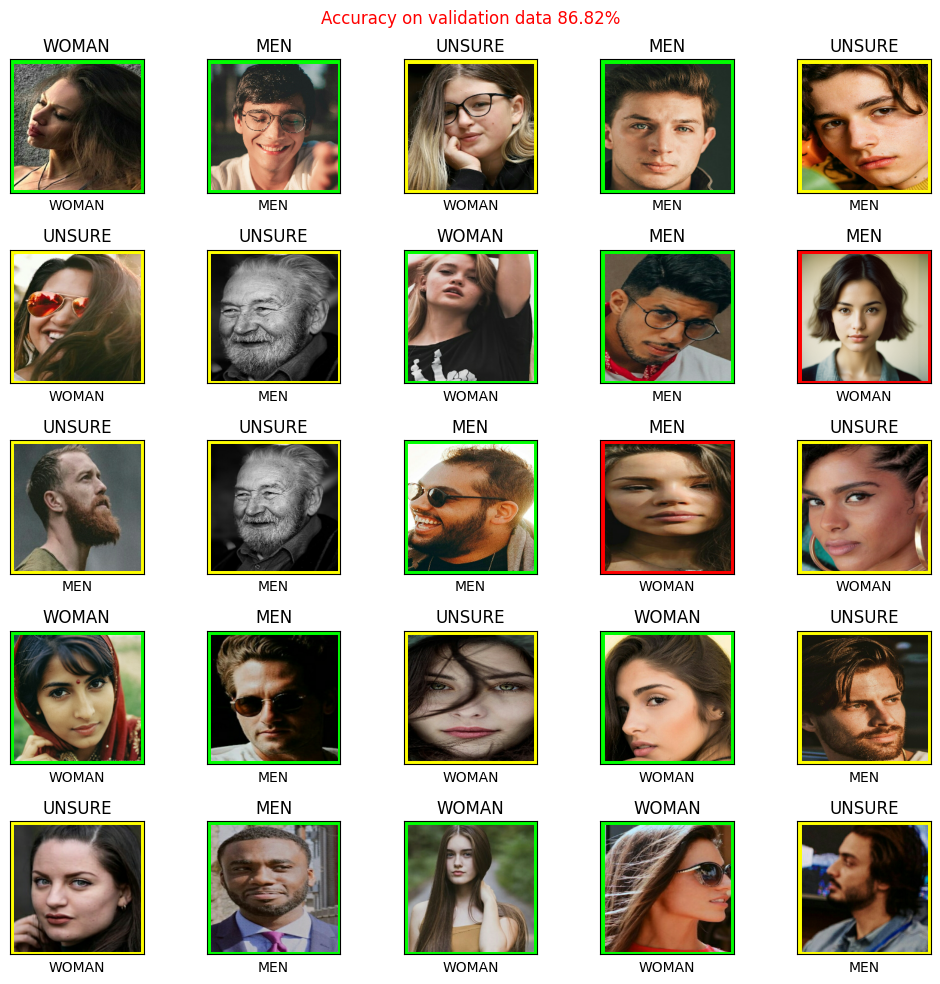

In [13]:
predictions_V2_augm = prediction_and_visualize(model_V2_augm, val_data)

#Residual Neural Network

In [14]:
MNv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
MNv2.trainable = False

model_v3_MNv2 = keras.Sequential([
    layers.Rescaling(1./255),
    MNv2,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model_v3_MNv2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
model_v3_MNv2.fit(
    train_data,
    steps_per_epoch=50,
    epochs=50,
    validation_data=val_data,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
10/50 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.6168 - loss: 5.7616

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 301ms/step - accuracy: 0.7864 - loss: 3.4521 - val_accuracy: 0.9612 - val_loss: 0.6136
Epoch 2/50
 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9635 - loss: 0.1851

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9549 - loss: 0.4106 - val_accuracy: 0.9535 - val_loss: 0.2302
Epoch 3/50
 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.9375 - loss: 0.1128

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9800 - loss: 0.0580 - val_accuracy: 0.9535 - val_loss: 0.2087
Epoch 4/50
 4/50 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9954 - loss: 0.0163

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9909 - loss: 0.0197 - val_accuracy: 0.9690 - val_loss: 0.2039
Epoch 5/50
12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9945 - loss: 0.0178

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9968 - loss: 0.0118 - val_accuracy: 0.9690 - val_loss: 0.2379
Epoch 6/50
 2/50 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 1.0000 - loss: 0.0042  

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9969 - loss: 0.0142 - val_accuracy: 0.9729 - val_loss: 0.2613
Epoch 7/50
 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9959 - loss: 0.0109

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9930 - loss: 0.0144 - val_accuracy: 0.9690 - val_loss: 0.2442
Epoch 8/50
 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 2.7231e-04

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9943 - loss: 0.0187 - val_accuracy: 0.9651 - val_loss: 0.2189
Epoch 9/50
 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9972 - loss: 0.0095

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9966 - loss: 0.0086 - val_accuracy: 0.9574 - val_loss: 0.2456
Epoch 10/50
 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9878 - loss: 0.0244

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9938 - loss: 0.0142 - val_accuracy: 0.9612 - val_loss: 0.2251
Epoch 11/50
 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9990 - loss: 0.0080

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9981 - loss: 0.0070 - val_accuracy: 0.9690 - val_loss: 0.2498
Epoch 12/50
 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 0.0020

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.9984 - loss: 0.0054 - val_accuracy: 0.9690 - val_loss: 0.2181
Epoch 13/50
 1/50 ━━━━━━━━━━━━━━━━━━━━ 44s 899ms/step - accuracy: 1.0000 - loss: 1.8101e-04

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9987 - loss: 0.0072 - val_accuracy: 0.9574 - val_loss: 0.3227
Epoch 14/50
 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9975 - loss: 0.0120    

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9930 - loss: 0.0251 - val_accuracy: 0.9651 - val_loss: 0.3755
Epoch 15/50
18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9922 - loss: 0.0143

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9928 - loss: 0.0128 - val_accuracy: 0.9535 - val_loss: 0.6106


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 567ms/step


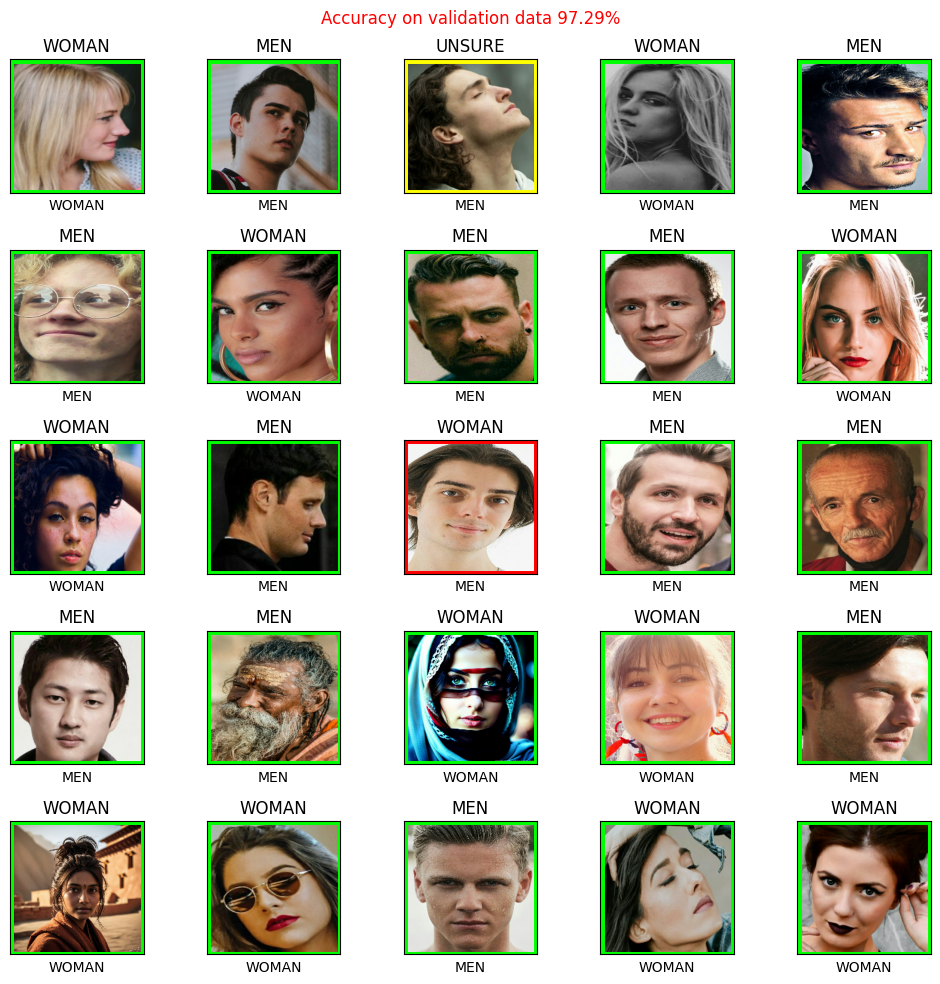

In [16]:
predictions_v3_MNv2 = prediction_and_visualize(model_v3_MNv2,val_data)

Continue training with trainable imagenet

In [17]:
for layer in MNv2.layers[-30:]:
    layer.trainable = True

In [18]:
model_v3_MNv2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [19]:
model_v3_MNv2.fit(
    train_data,
    steps_per_epoch=50,
    epochs=50,
    validation_data=val_data,
    callbacks=[early_stopping_callback]
)

Epoch 1/50


Invalid SOS parameters for sequential JPEG
E0000 00:00:1753294771.993112      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753294772.189936      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


32/50 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9340 - loss: 0.2411

E0000 00:00:1753294782.390940      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753294782.586469      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 343ms/step - accuracy: 0.9334 - loss: 0.2455 - val_accuracy: 0.9651 - val_loss: 0.2612
Epoch 2/50
 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9364 - loss: 0.2602

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9551 - loss: 0.1823 - val_accuracy: 0.9574 - val_loss: 0.2721
Epoch 3/50
15/50 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9596 - loss: 0.1240

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9663 - loss: 0.1103 - val_accuracy: 0.9612 - val_loss: 0.2603
Epoch 4/50
22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9641 - loss: 0.0851

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9688 - loss: 0.0821 - val_accuracy: 0.9612 - val_loss: 0.2617
Epoch 5/50
24/50 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9720 - loss: 0.0668

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9727 - loss: 0.0697 - val_accuracy: 0.9574 - val_loss: 0.2728
Epoch 6/50
 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9483 - loss: 0.1364

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9711 - loss: 0.0729 - val_accuracy: 0.9690 - val_loss: 0.2631
Epoch 7/50
 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9857 - loss: 0.0844

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9840 - loss: 0.0544 - val_accuracy: 0.9690 - val_loss: 0.2666
Epoch 8/50
 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 0.0145 

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9940 - loss: 0.0177 - val_accuracy: 0.9690 - val_loss: 0.2736
Epoch 9/50
 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9948 - loss: 0.0165

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9901 - loss: 0.0260 - val_accuracy: 0.9690 - val_loss: 0.2755
Epoch 10/50
 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.9965 - loss: 0.0116

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9946 - loss: 0.0168 - val_accuracy: 0.9612 - val_loss: 0.2842
Epoch 11/50
 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 0.0075

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9935 - loss: 0.0165 - val_accuracy: 0.9651 - val_loss: 0.2821
Epoch 12/50
25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9864 - loss: 0.0230

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9899 - loss: 0.0191 - val_accuracy: 0.9651 - val_loss: 0.2825
Epoch 13/50
 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9845 - loss: 0.0360

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9866 - loss: 0.0282 - val_accuracy: 0.9651 - val_loss: 0.2794
Epoch 14/50
 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9837 - loss: 0.0135

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9965 - loss: 0.0092 - val_accuracy: 0.9651 - val_loss: 0.2865
Epoch 15/50
 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 0.0035

Invalid SOS parameters for sequential JPEG


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9965 - loss: 0.0103 - val_accuracy: 0.9651 - val_loss: 0.2923


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 485ms/step


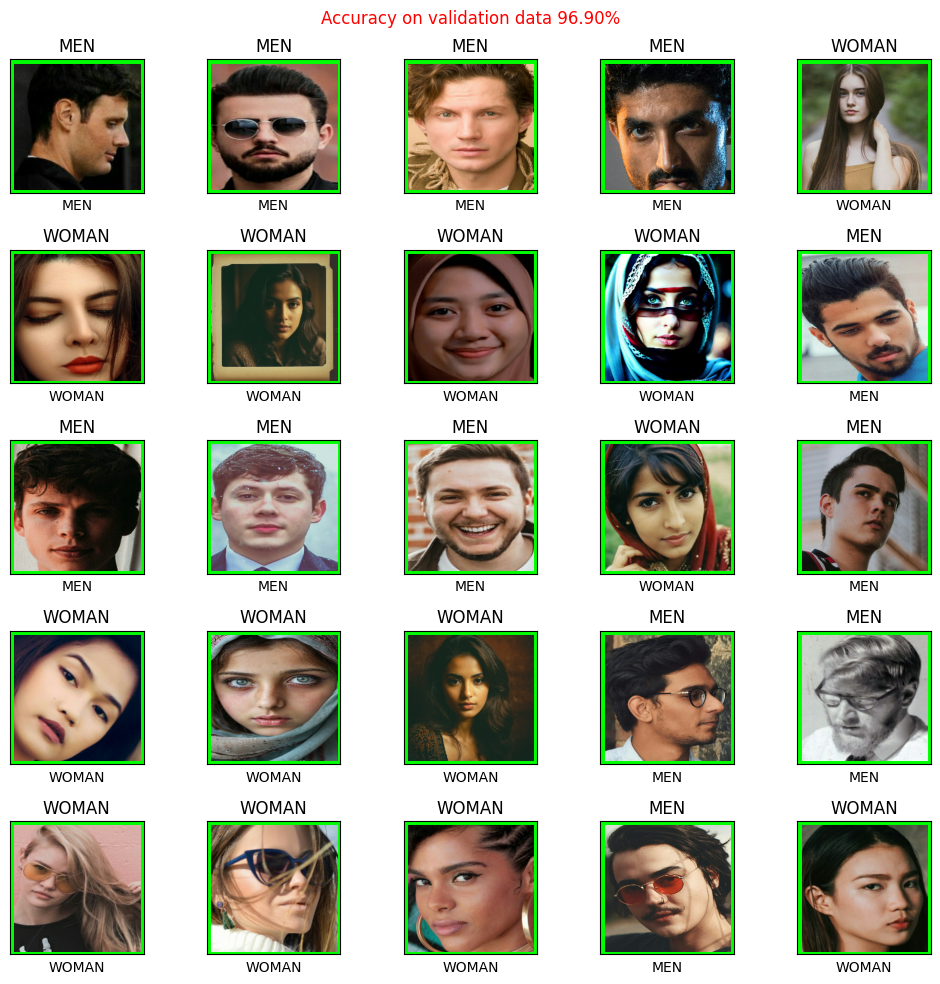

In [20]:
predictions_v3_MNv2_trainable = prediction_and_visualize(model_v3_MNv2,val_data)

In [21]:
model_v3_MNv2.save('model_v3_MNv2.h5')